# TASK 1 - Similarity Patterns (Zisan Aalam - a1975528)

### 1. Import Libraries and Read the dataset

In [1]:
# import required libraries
import pandas as pd
import numpy as np
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [2]:
# read data set
df = pd.read_csv("Groceries data train.csv")
test_df = pd.read_csv("Groceries data test.csv")

In [3]:
print("Data shape:", df.shape)
print("\nFirst few rows of the dataset:")
df.head()

Data shape: (27000, 7)

First few rows of the dataset:


,Member_number,Date,itemDescription,year,month,day,day_of_week
0,3021,30/01/2015,frankfurter,2015,1,30,4
1,1292,24/10/2015,pork,2015,10,24,5
2,4206,4/04/2014,root vegetables,2014,4,4,4
3,4369,25/08/2015,onions,2015,8,25,1
4,1522,1/07/2014,waffles,2014,7,1,1


### 2. Check Missing Values and Clean Data

In [4]:
# checking for null or missing value
print("\nMissing values in each column:")
df_missing = pd.DataFrame((round(100 * (df.isnull().sum() / len(df.index)), 2)), columns=['missing'])
df_missing


Missing values in each column:


,missing
Member_number,0.0
Date,0.0
itemDescription,0.0
year,0.0
month,0.0
day,0.0
day_of_week,0.0


As there are no any missing values in the data, we don't have do any null filling

In [5]:
# List all the unique item names to check for and address any unusual, inconsistent, or incorrect entries before analysis.
df['itemDescription'].unique()

array(['frankfurter', 'pork', 'root vegetables', 'onions', 'waffles',
       'cereals', 'yogurt', 'sausage', 'rolls/buns', 'chocolate',
       'whipped/sour cream', 'butter', 'curd', 'frozen meals',
       'whole milk', 'tropical fruit', 'sugar', 'specialty cheese',
       'other vegetables', 'fruit/vegetable juice', 'misc. beverages',
       'frozen vegetables', 'spices', 'coffee', 'cream cheese ',
       'red/blush wine', 'dessert', 'long life bakery product',
       'domestic eggs', 'abrasive cleaner', 'berries',
       'liquor (appetizer)', 'semi-finished bread', 'newspapers',
       'beverages', 'beef', 'female sanitary products', 'salt', 'soda',
       'sauces', 'oil', 'snack products', 'brown bread',
       'hygiene articles', 'artif. sweetener', 'bottled beer',
       'canned beer', 'hamburger meat', 'liver loaf', 'soups',
       'pip fruit', 'hard cheese', 'shopping bags', 'canned vegetables',
       'napkins', 'citrus fruit', 'margarine', 'pasta', 'salty snack',
       'candl

There are no any item  with unusual, misspelled, or inconsistent item names. However some items have trailing spaces (e.g., 'cream cheese ' vs 'cream cheese', 'roll products '), which should be stripped

In [6]:
# Clean itemDescription
df['itemDescription'] = df['itemDescription'].str.strip()

### 3. Create Transcation

In [7]:
basket_df = df.groupby(['Member_number', 'Date'])['itemDescription'].apply(list).reset_index()
basket_df_t = test_df.groupby(['Member_number', 'Date'])['itemDescription'].apply(list).reset_index()
transactions = basket_df['itemDescription'].tolist()
transactions_t = basket_df_t['itemDescription'].tolist()

To prepare the data for association rule mining using the Apriori algorithm, we first group individual purchase records by customer and date, combining all items bought in a single shopping trip into a list that represents one transaction or basket. By converting the data into this transaction-based format, we create a list of itemsets where each set reflects the products purchased together in a single visit. This transformation is essential because Apriori and similar algorithms require input as a list of transactions to effectively identify frequent item combinations and discover meaningful association rules, ultimately helping us understand which products are commonly bought together.

#### Note:
I attempted to group the records by week and year, as well as by month and year, to see if this aggregation would improve the results. While the association rules performed well when applied to the grouped item data, they did not yield strong or meaningful results when evaluated on individual items. As a result, grouping by week or month did not enhance the quality of the discovered rules for individual product recommendations.

In [8]:
basket_df.head()

,Member_number,Date,itemDescription
0,1000,15/03/2015,"[sausage, yogurt]"
1,1000,24/06/2014,[pastry]
2,1000,24/07/2015,"[misc. beverages, canned beer]"
3,1000,25/11/2015,[sausage]
4,1000,27/05/2015,"[soda, pickled vegetables]"


In [9]:
# Top 20 most frequent items
item_counts = Counter([item for sublist in transactions for item in sublist])
item_counts_t = Counter([item for sublist in transactions_t for item in sublist])
print(item_counts.most_common(20))

[('whole milk', 1709), ('other vegetables', 1320), ('rolls/buns', 1197), ('soda', 1060), ('yogurt', 928), ('root vegetables', 733), ('tropical fruit', 683), ('bottled water', 666), ('sausage', 637), ('citrus fruit', 560), ('pastry', 558), ('pip fruit', 512), ('shopping bags', 499), ('bottled beer', 493), ('canned beer', 488), ('whipped/sour cream', 470), ('brown bread', 415), ('newspapers', 414), ('frankfurter', 411), ('domestic eggs', 400)]


The result shows that "whole milk" is the most frequently purchased item with 1,709 occurrences, followed by "other vegetables" (1,320), "rolls/buns" (1,197), and "soda" (1,060). Other popular items include "yogurt," "root vegetables," "tropical fruit," and "bottled water." These top 20 items represent the most commonly bought products in the dataset, indicating they are staple or highly preferred choices among customers.

### 4. Data Encoding

In [10]:
# Transaction Encoding for Apriori
encoder = TransactionEncoder()
encoded_transcation = encoder.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(encoded_transcation, columns=encoder.columns_)

In [11]:
encoder = TransactionEncoder()
encoded_transcation_t = encoder.fit(transactions_t).transform(transactions_t)
df_encoded_t = pd.DataFrame(encoded_transcation_t, columns=encoder.columns_)

To prepare the transaction data for use with the Apriori algorithm, applied a transaction encoding process that converts each basket of purchased items into a structured, machine-readable format. Using the TransactionEncoder, transformed the list of transactions into a binary matrix, where each row represents a transaction and each column corresponds to a unique product. This transformation is essential because Apriori algorithms require input in this one-hot encoded format to efficiently identify frequent itemsets and generate association rules.

### 5. Parameter Tuning for min support

In [12]:
min_support_values = [0.01, 0.02, 0.03, 0.05]
min_support_values = [0.001, 0.002, 0.0025, 0.003,0.004, 0.005, 0.008]
results = {}

for min_support in min_support_values:
    frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)
    results[min_support] = frequent_itemsets
    print(f"\nFrequent itemsets for min_support={min_support}:")
    print(frequent_itemsets.sort_values('support', ascending=False))


Frequent itemsets for min_support=0.001:
      support                    itemsets
135  0.118049                (whole milk)
84   0.092799          (other vegetables)
101  0.083519                (rolls/buns)
114  0.074095                      (soda)
136  0.064312                    (yogurt)
..        ...                         ...
240  0.001007       (shopping bags, curd)
213  0.001007             (soda, chicken)
244  0.001007       (rolls/buns, dessert)
139  0.001007  (UHT-milk, tropical fruit)
215  0.001007           (yogurt, chicken)

[397 rows x 2 columns]

Frequent itemsets for min_support=0.002:
      support                   itemsets
112  0.118049               (whole milk)
68   0.092799         (other vegetables)
83   0.083519               (rolls/buns)
93   0.074095                     (soda)
113  0.064312                   (yogurt)
..        ...                        ...
132  0.002014      (whole milk, chicken)
177  0.002014  (yogurt, root vegetables)
95   0.002014      

In [13]:
# Frequent Itemset Mining with Apriori
# Parameter tuning
# min_support_values = [0.01, 0.02, 0.03, 0.05]
min_support_values = [0.001, 0.002, 0.0025, 0.003,0.004, 0.005, 0.008]
results = {}

for min_support in min_support_values:
    frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)
    results[min_support] = frequent_itemsets
    print(f"\nFrequent itemsets for min_support={min_support}:")
    print(frequent_itemsets.sort_values('support', ascending=False))


Frequent itemsets for min_support=0.001:
      support                    itemsets
135  0.118049                (whole milk)
84   0.092799          (other vegetables)
101  0.083519                (rolls/buns)
114  0.074095                      (soda)
136  0.064312                    (yogurt)
..        ...                         ...
240  0.001007       (shopping bags, curd)
213  0.001007             (soda, chicken)
244  0.001007       (rolls/buns, dessert)
139  0.001007  (UHT-milk, tropical fruit)
215  0.001007           (yogurt, chicken)

[397 rows x 2 columns]

Frequent itemsets for min_support=0.002:
      support                   itemsets
112  0.118049               (whole milk)
68   0.092799         (other vegetables)
83   0.083519               (rolls/buns)
93   0.074095                     (soda)
113  0.064312                   (yogurt)
..        ...                        ...
132  0.002014      (whole milk, chicken)
177  0.002014  (yogurt, root vegetables)
95   0.002014      

To identify sets of items that are frequently purchased together, performed frequent itemset mining using the Apriori algorithm. Experimented with different values for the min_support parameter, which determines the minimum proportion of transactions in which an itemset must appear to be considered frequent. By iterating over a range of min_support values, generated and examined frequent itemsets for each threshold, storing the results for comparison. This approach allows us to observe how changing the minimum support affects the number and composition of frequent itemsets, helping us select the most appropriate parameter for uncovering meaningful patterns in the data. The frequent itemsets identified at each support level form the basis for generating association rules in subsequent analysis.

As the min_support threshold decreases from 0.008 to 0.001, the number of frequent itemsets increases significantly. Higher thresholds, such as 0.008, capture only the most commonly purchased items and combinations like “whole milk,” “other vegetables,” and “rolls/buns” resulting in a small set of 63 itemsets. Lowering the threshold introduces less frequent and more niche itemsets, reaching a total of 397 at min_support = 0.001. While this increase captures more variety, it also introduces noise and adds unnecessary complexity to the analysis. A threshold of min_support = 0.0025 strikes a practical balance by narrowing the itemsets down to 155. This value filters out overly rare combinations while retaining meaningful and diverse patterns, such as (whole milk, whipped/sour cream) and (pip fruit, other vegetables), making it well suited for subsequent confidence tuning and rule generation.


### 6. Visualizing group itemset

In [14]:
# Show frequent itemsets with more than one item
for min_support in min_support_values:
    fi = results[min_support]
    multi_itemsets = fi[fi['itemsets'].apply(lambda x: len(x) > 1)]
    print(f"\nFrequent itemsets with more than one item for min_support={min_support}:")
    print(multi_itemsets)


Frequent itemsets with more than one item for min_support=0.001:
      support                          itemsets
138  0.001223      (UHT-milk, other vegetables)
139  0.001007        (UHT-milk, tropical fruit)
140  0.001583            (UHT-milk, whole milk)
141  0.001079               (beef, brown bread)
142  0.001079              (beef, citrus fruit)
..        ...                               ...
392  0.001511             (waffles, whole milk)
393  0.002518  (whole milk, whipped/sour cream)
394  0.001726      (whipped/sour cream, yogurt)
395  0.001870         (white bread, whole milk)
396  0.006546              (whole milk, yogurt)

[259 rows x 2 columns]

Frequent itemsets with more than one item for min_support=0.002:
      support                          itemsets
115  0.002446                (beef, whole milk)
116  0.002518  (other vegetables, bottled beer)
117  0.002302        (rolls/buns, bottled beer)
118  0.003741        (whole milk, bottled beer)
119  0.002014            (yo

The results show how minimum support thresholds dramatically filter multi-item frequent itemsets, revealing the most meaningful product combinations. At low support (0.001), we get 259 pairs including many weak associations like "UHT-milk, tropical fruit" (0.1% support), but as support increases to 0.005, only 7 high-quality pairs remain, dominated by essential grocery combinations: "whole milk + other vegetables" (0.70%), "whole milk + rolls/buns" (0.79%), and "other vegetables + soda" (0.55%). Notably, at 0.008 support, no multi-item combinations survive, indicating this threshold is too restrictive. This visualization shows the foundation itemsets from which association rules are generated - as we can only create rules from frequent itemsets, so understanding which product pairs actually co-occur frequently enough helps to focus on the most reliable associations.

### 7. Parameter Tuning for min confidence

In [15]:
chosen_support = 0.0025
frequent_itemsets = results[chosen_support]

# 5. Association Rule Mining
min_confidence_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
for min_conf in min_confidence_values:
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_conf)
    rules = rules.sort_values('lift', ascending=False)
    print(f"\nAssociation Rules for min_confidence={min_conf} : Count {len(rules)}")
    print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(20))


Association Rules for min_confidence=0.01 : Count 98
           antecedents         consequents   support  confidence      lift
28       (frankfurter)  (other vegetables)  0.003093    0.107232  1.155528
29  (other vegetables)       (frankfurter)  0.003093    0.033333  1.155528
83            (yogurt)           (sausage)  0.003237    0.050336  1.112424
82           (sausage)            (yogurt)  0.003237    0.071542  1.112424
84              (soda)     (shopping bags)  0.002877    0.038835  1.099480
85     (shopping bags)              (soda)  0.002877    0.081466  1.099480
57         (pip fruit)        (rolls/buns)  0.003093    0.084813  1.015487
56        (rolls/buns)         (pip fruit)  0.003093    0.037037  1.015487
24      (citrus fruit)            (yogurt)  0.002590    0.065099  1.012246
25            (yogurt)      (citrus fruit)  0.002590    0.040268  1.012246
78           (sausage)              (soda)  0.003309    0.073132  0.986997
79              (soda)           (sausage)  0.

To determine an appropriate value for the min_confidence parameter in association rule mining, a range of thresholds from 0.01 to 0.10 was evaluated. The primary goal was to strike a balance between the quantity of generated rules and their reliability (measured by confidence).

At lower confidence thresholds such as 0.01 and 0.02, a larger number of rules (98) were generated. However, many of these rules had relatively weak confidence values, making them less reliable for drawing actionable insights.

As the threshold increased, the number of rules gradually decreased:

- At 0.03, there were 81 rules.

- At 0.04, 64 rules.

- At 0.05, 57 rules

- At 0.06, at 45 rules


When the threshold reached 0.08, only 14 rules remained.

This sharp drop beyond 0.06 indicated that higher thresholds filtered out a large portion of potentially useful rules, possibly overlooking important associations with slightly lower confidence but reasonable lift.

Setting min_confidence = 0.06 offered a practical compromise:

- It filtered out weaker rules found at lower thresholds.

- It retained a meaningful number of strong and interpretable rules with acceptable confidence and lift.

- It avoided the overly strict cutoff that results in very few rules, such as at 0.08 or higher.

### 8. Regenerating Rules

In [16]:
frequent_itemsets = apriori(df_encoded, min_support=0.0025, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.06)
rules = rules.sort_values(['confidence','lift'],ascending=[False,False])
print("Totoal number or rules genereted :: ",len(rules))
print(rules)

Totoal number or rules genereted ::  45
                antecedents         consequents  antecedent support  \
37                (sausage)        (whole milk)            0.045249   
13            (frankfurter)        (whole milk)            0.028847   
11          (domestic eggs)        (whole milk)            0.028343   
12            (frankfurter)  (other vegetables)            0.028847   
1            (bottled beer)        (whole milk)            0.035105   
5                  (butter)        (whole milk)            0.027120   
40          (shopping bags)        (whole milk)            0.035321   
44                 (yogurt)        (whole milk)            0.064312   
14  (fruit/vegetable juice)        (whole milk)            0.025969   
27                   (pork)        (whole milk)            0.027336   
32             (rolls/buns)        (whole milk)            0.083519   
15             (newspapers)        (whole milk)            0.029135   
26              (pip fruit)        (w

In [17]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
37,(sausage),(whole milk),0.045249,0.118049,0.005251,0.116057,0.983127,1.0,-0.000090,0.997747,-0.017658,0.033227,-0.002258,0.080271
13,(frankfurter),(whole milk),0.028847,0.118049,0.003237,0.112219,0.950617,1.0,-0.000168,0.993434,-0.050775,0.022534,-0.006610,0.069821
11,(domestic eggs),(whole milk),0.028343,0.118049,0.003093,0.109137,0.924506,1.0,-0.000253,0.989996,-0.077526,0.021586,-0.010105,0.067670
12,(frankfurter),(other vegetables),0.028847,0.092799,0.003093,0.107232,1.155528,1.0,0.000416,1.016166,0.138593,0.026092,0.015909,0.070283
1,(bottled beer),(whole milk),0.035105,0.118049,0.003741,0.106557,0.902653,1.0,-0.000403,0.987138,-0.100532,0.025036,-0.013030,0.069123
5,(butter),(whole milk),0.027120,0.118049,0.002806,0.103448,0.876316,1.0,-0.000396,0.983715,-0.126695,0.019707,-0.016555,0.063607
40,(shopping bags),(whole milk),0.035321,0.118049,0.003597,0.101833,0.862633,1.0,-0.000573,0.981945,-0.141684,0.024015,-0.018387,0.066151
44,(yogurt),(whole milk),0.064312,0.118049,0.006546,0.101790,0.862266,1.0,-0.001046,0.981898,-0.145820,0.037234,-0.018436,0.078622
14,(fruit/vegetable juice),(whole milk),0.025969,0.118049,0.002590,0.099723,0.844759,1.0,-0.000476,0.979644,-0.158723,0.018311,-0.020779,0.060830
27,(pork),(whole milk),0.027336,0.118049,0.002662,0.097368,0.824813,1.0,-0.000565,0.977089,-0.179228,0.018649,-0.023449,0.059958


In [18]:
# --- Step 1: Convert to list of transactions ---
transactions_t = test_df['itemDescription'].tolist()

# --- Step 2: One-hot encode the transaction list ---
te = TransactionEncoder()
te_ary = te.fit(transactions_t).transform(transactions_t)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# --- Step 4: Recalculate support/confidence on a test split (simulate by using second half as test) ---
split_idx = len(df_encoded) // 2
df_train = df_encoded.iloc[:split_idx]
df_test = df_encoded.iloc[split_idx:]

def calc_support_confidence(rule, df_bin):
    antecedents = set(rule['antecedents'])
    consequents = set(rule['consequents'])

    if not antecedents or not consequents:
        return 0.0, 0.0

    antecedent_mask = df_bin[list(antecedents)].all(axis=1)
    both_mask = df_bin[list(antecedents.union(consequents))].all(axis=1)

    support = both_mask.sum() / len(df_bin)
    confidence = both_mask.sum() / antecedent_mask.sum() if antecedent_mask.sum() > 0 else 0
    return support, confidence

results = []
for _, row in rules.iterrows():
    test_support, test_confidence = calc_support_confidence(row, df_encoded_t)
    results.append({
        'antecedents': row['antecedents'],
        'consequents': row['consequents'],
        'support_train': round(row['support'], 4),
        'confidence_train': round(row['confidence'], 4),
        'support_test': round(test_support, 4),
        'confidence_test': round(test_confidence, 4),
    })

results_df = pd.DataFrame(results)
top_5_rules = results_df.sort_values(by='confidence_train', ascending=False).head(5)
top_5_rules

,antecedents,consequents,support_train,confidence_train,support_test,confidence_test
0,(sausage),(whole milk),0.0053,0.1161,0.0010,0.0316
1,(frankfurter),(whole milk),0.0032,0.1122,0.0008,0.0414
2,(domestic eggs),(whole milk),0.0031,0.1091,0.0007,0.0361
3,(frankfurter),(other vegetables),0.0031,0.1072,0.0007,0.0355
4,(bottled beer),(whole milk),0.0037,0.1066,0.0009,0.0415


In [19]:
whole_milk = results_df['consequents'][0]

In [20]:
results_df[results_df['consequents'] != whole_milk]

,antecedents,consequents,support_train,confidence_train,support_test,confidence_test
3,(frankfurter),(other vegetables),0.0031,0.1072,0.0007,0.0355
17,(pip fruit),(rolls/buns),0.0031,0.0848,0.0006,0.0216
18,(shopping bags),(soda),0.0029,0.0815,0.0005,0.0174
21,(shopping bags),(rolls/buns),0.0028,0.0794,0.0007,0.0261
22,(shopping bags),(other vegetables),0.0027,0.0774,0.0007,0.0261
26,(citrus fruit),(other vegetables),0.0029,0.0741,0.0006,0.0200
27,(soda),(other vegetables),0.0055,0.0738,0.0016,0.0312
28,(sausage),(soda),0.0033,0.0731,0.0008,0.0246
29,(bottled beer),(other vegetables),0.0025,0.0717,0.0005,0.0207
30,(sausage),(yogurt),0.0032,0.0715,0.0011,0.0351


Using a minimum support of 0.0025 and minimum confidence of 0.06, the association rule mining generated 45 rules showing relationships between items frequently bought together. Most rules involve "whole milk" as the consequent, indicating it is commonly purchased alongside items like sausage, frankfurter, rolls/buns, and other vegetables. The support values are generally low but above the threshold, meaning these itemsets appear in at least 0.25% of transactions. Confidence values range around 6-11%, showing a moderate likelihood that when the antecedent items are bought, the consequent item is also purchased. However, many lifts are close to or below 1, indicating the associations are only slightly stronger than random chance. Overall, these rules reveal some meaningful but not very strong buying patterns within the dataset.

### 8. Visualization


Top 5 Rules by Lift:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,coverage,zhang_metric
12,(frankfurter),(other vegetables),0.028847,0.092799,0.003093,0.107232,1.155528,1.0,0.000416,1.016166,0.138593,0.026092,0.015909,0.070283,0.028847,0.015909
38,(sausage),(yogurt),0.045249,0.064312,0.003237,0.071542,1.112424,1.0,0.000327,1.007787,0.105852,0.030447,0.007727,0.060939,0.045249,0.007727
39,(shopping bags),(soda),0.035321,0.074095,0.002877,0.081466,1.099480,1.0,0.000260,1.008025,0.093792,0.027009,0.007961,0.060151,0.035321,0.007961
25,(pip fruit),(rolls/buns),0.036472,0.083519,0.003093,0.084813,1.015487,1.0,0.000047,1.001413,0.015828,0.026462,0.001411,0.060925,0.036472,0.001411
10,(citrus fruit),(yogurt),0.039781,0.064312,0.002590,0.065099,1.012246,1.0,0.000031,1.000842,0.012599,0.025514,0.000842,0.052684,0.039781,0.000842



Top 5 Rules by Confidence:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,coverage,zhang_metric
37,(sausage),(whole milk),0.045249,0.118049,0.005251,0.116057,0.983127,1.0,-0.000090,0.997747,-0.017658,0.033227,-0.002258,0.080271,0.045249,-0.002258
13,(frankfurter),(whole milk),0.028847,0.118049,0.003237,0.112219,0.950617,1.0,-0.000168,0.993434,-0.050775,0.022534,-0.006610,0.069821,0.028847,-0.006610
11,(domestic eggs),(whole milk),0.028343,0.118049,0.003093,0.109137,0.924506,1.0,-0.000253,0.989996,-0.077526,0.021586,-0.010105,0.067670,0.028343,-0.010105
12,(frankfurter),(other vegetables),0.028847,0.092799,0.003093,0.107232,1.155528,1.0,0.000416,1.016166,0.138593,0.026092,0.015909,0.070283,0.028847,0.015909
1,(bottled beer),(whole milk),0.035105,0.118049,0.003741,0.106557,0.902653,1.0,-0.000403,0.987138,-0.100532,0.025036,-0.013030,0.069123,0.035105,-0.013030



Top 5 Rules by Support:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,coverage,zhang_metric
32,(rolls/buns),(whole milk),0.083519,0.118049,0.007913,0.094746,0.802598,1.0,-0.001946,0.974258,-0.211585,0.040862,-0.026422,0.080889,0.083519,-0.026422
33,(whole milk),(rolls/buns),0.118049,0.083519,0.007913,0.067032,0.802598,1.0,-0.001946,0.982329,-0.218063,0.040862,-0.017989,0.080889,0.118049,-0.017989
22,(other vegetables),(whole milk),0.092799,0.118049,0.006978,0.075194,0.636971,1.0,-0.003977,0.953660,-0.385836,0.034227,-0.048591,0.067152,0.092799,-0.048591
44,(yogurt),(whole milk),0.064312,0.118049,0.006546,0.101790,0.862266,1.0,-0.001046,0.981898,-0.145820,0.037234,-0.018436,0.078622,0.064312,-0.018436
41,(soda),(whole milk),0.074095,0.118049,0.005971,0.080583,0.682619,1.0,-0.002776,0.959250,-0.334289,0.032071,-0.042481,0.065581,0.074095,-0.042481


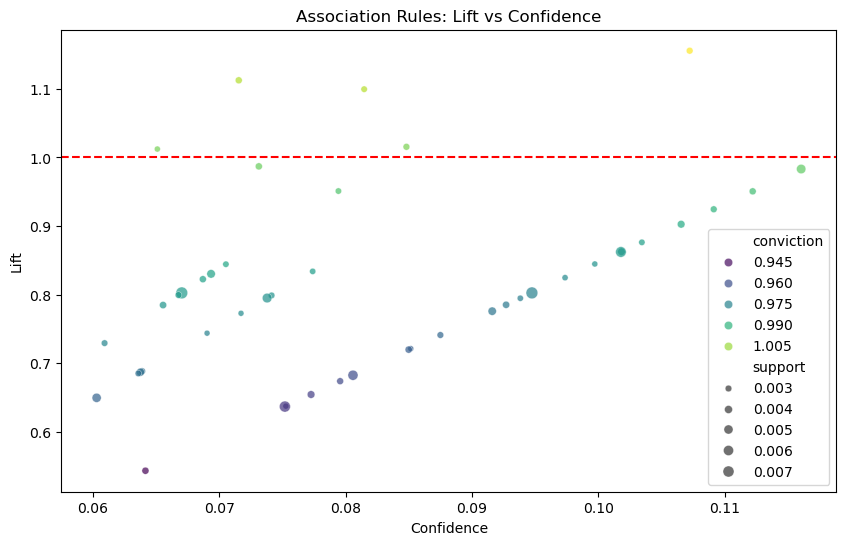


Actionable Rules:


,antecedents,consequents,support,confidence,lift
12,(frankfurter),(other vegetables),0.003093,0.107232,1.155528
38,(sausage),(yogurt),0.003237,0.071542,1.112424
39,(shopping bags),(soda),0.002877,0.081466,1.099480
25,(pip fruit),(rolls/buns),0.003093,0.084813,1.015487
10,(citrus fruit),(yogurt),0.002590,0.065099,1.012246
36,(sausage),(soda),0.003309,0.073132,0.986997
37,(sausage),(whole milk),0.005251,0.116057,0.983127
30,(shopping bags),(rolls/buns),0.002806,0.079430,0.951036
13,(frankfurter),(whole milk),0.003237,0.112219,0.950617
11,(domestic eggs),(whole milk),0.003093,0.109137,0.924506


In [21]:
# Add additional metrics (e.g., coverage, coverage ratio)
rules['coverage'] = rules['antecedents'].apply(
    lambda x: frequent_itemsets[frequent_itemsets['itemsets'] == x]['support'].values[0]
)
rules['zhang_metric'] = (rules['confidence'] - rules['consequent support']) / (1 - rules['consequent support'])

# Display Top Rules by Different Metrics
def display_top_rules(rules, metric='lift', top_n=5):
    return rules.sort_values(metric, ascending=False).head(top_n)

print("\nTop 5 Rules by Lift:")
display(display_top_rules(rules, 'lift'))

print("\nTop 5 Rules by Confidence:")
display(display_top_rules(rules, 'confidence'))

print("\nTop 5 Rules by Support:")
display(display_top_rules(rules, 'support'))

# Visualize Rule Quality
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='confidence', 
    y='lift', 
    size='support', 
    hue='conviction', 
    data=rules,
    alpha=0.7,
    palette='viridis'
)
plt.title('Association Rules: Lift vs Confidence')
plt.xlabel('Confidence')
plt.ylabel('Lift')
plt.axhline(1, linestyle='--', color='red')  # Lift=1 baseline
plt.show()

# Filter and Interpret Actionable Rules
actionable_rules = rules.sort_values('lift', ascending=False)

print("\nActionable Rules:")
display(actionable_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

#### Top 5 Rules by Lift
Lift measures how much more likely the consequent is to occur when the antecedent is present compared to when it is not.
- The top rule: (frankfurter) → (other vegetables) has the highest lift (1.155), indicating a positive association beyond chance.
- Other top pairs like (sausage) → (yogurt) and (shopping bags) → (soda) also show non-random associations.
- These rules have moderate confidence and low support, suggesting rare but strong links.

#### Top 5 Rules by Confidence
Confidence is the conditional probability of the consequent given the antecedent.
- The rule (sausage) → (whole milk) has the highest confidence (0.116), meaning when sausage is bought, whole milk is also bought 11.6% of the time.
- Rules like (frankfurter) → (whole milk) and (domestic eggs) → (whole milk) also show high confidence.
- Interestingly, many of these high-confidence rules have low lift, indicating that the high probability is influenced by the popularity of whole milk, not necessarily a strong association.

#### Top 5 Rules by Support
Support is the frequency of the combined items (antecedent + consequent) in transactions.
- The most frequent rule is (whole milk) → (rolls/buns) with support 0.0079 (i.e., in 0.79% of transactions).
- These rules reflect combinations of commonly purchased items.
- They usually have lower lift and confidence, suggesting they occur often but may not have strong predictive power.

#### Actionable Rules (Sorted by Lift)
These rules are filtered by descending lift, making them highly useful for business decision-making.

- Top actionable rule: (frankfurter) → (other vegetables) with highest lift (1.155), good confidence, but low support.
- Many rules in this list have moderate support and good confidence, suggesting niche but potentially valuable insights, like targeting customers buying frankfurter or sausage for promoting yogurt or other vegetables.

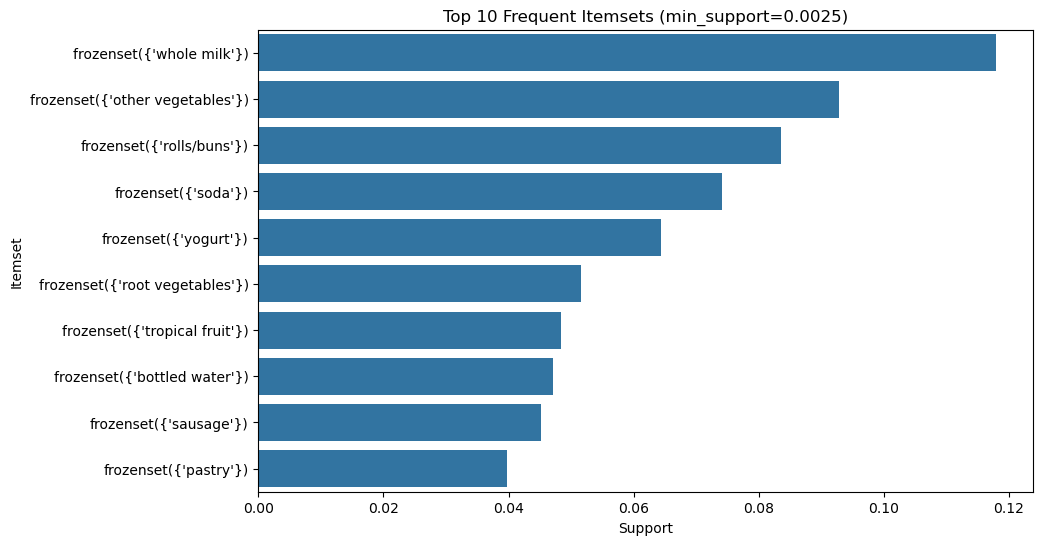

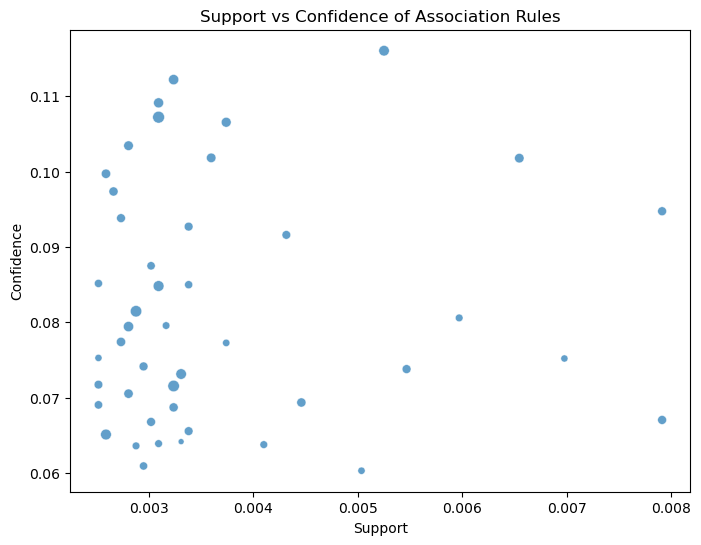

Text(0, 0.5, 'Frequency')

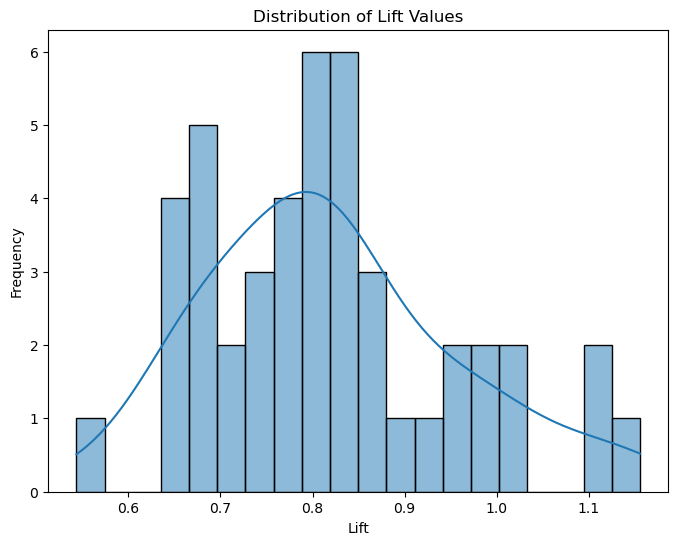

In [22]:
# Top N frequent itemsets
top_n = 10
top_itemsets = frequent_itemsets.sort_values('support', ascending=False).head(top_n)
plt.figure(figsize=(10,6))
sns.barplot(x='support', y=top_itemsets['itemsets'].astype(str), data=top_itemsets)
plt.title(f'Top {top_n} Frequent Itemsets (min_support={chosen_support})')
plt.xlabel('Support')
plt.ylabel('Itemset')
plt.show()

# Support vs Confidence Scatter Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x='support', y='confidence', size='lift', data=rules, legend=False, alpha=0.7)
plt.title('Support vs Confidence of Association Rules')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.show()

# Lift Distribution Histogram
plt.figure(figsize=(8,6))
sns.histplot(rules['lift'], bins=20, kde=True)
plt.title('Distribution of Lift Values')
plt.xlabel('Lift')
plt.ylabel('Frequency')
# plt.show()

#### Support vs Confidence of Association Rules
Most of the rules have low support (below 0.004) and moderate confidence (between 0.06 and 0.11), indicating that while the rules may not occur frequently, they are relatively reliable when they do. A few rules with higher support also show higher confidence, making them potentially more valuable for decision-making. The varying point sizes suggest that some of these rules, despite low support, still have a high lift, implying strong associations.

In [23]:
def recommend_items(items, rules, top_n=5):
    items_set = set(items)
    recommendations = {}

    for idx, row in rules.iterrows():
        antecedent = set(row['antecedents'])
        consequent = set(row['consequents'])

        # If all antecedent items are in the basket and none of the consequent items are
        if antecedent.issubset(items_set) and not consequent.issubset(items_set):
            for item in consequent:
                if item not in items_set:
                    # Keep the highest confidence for each recommended item
                    if item not in recommendations or recommendations[item] < row['confidence']:
                        recommendations[item] = row['confidence']

    # Sort recommendations by confidence, descending
    recommended_list = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)
    return recommended_list[:top_n]


In [24]:
basket = ['frankfurter', 'sausage']
top_recs = recommend_items(basket, rules, top_n=3)
print("Recommendations:", top_recs)

Recommendations: [('whole milk', 0.11605723370429252), ('other vegetables', 0.10723192019950124), ('soda', 0.07313195548489666)]


In [25]:
basket = ['whole milk']
top_recs = recommend_items(basket, rules, top_n=3)
print("Recommendations:", top_recs)

Recommendations: [('rolls/buns', 0.06703229737964655)]


In [26]:
def save_rules_to_csv(rules, filename='association_rules.csv'):
    # Convert frozensets in 'antecedents' and 'consequents' to strings for CSV readability
    rules_to_save = rules.copy()
    if 'antecedents' in rules_to_save.columns:
        rules_to_save['antecedents'] = rules_to_save['antecedents'].apply(lambda x: ', '.join(list(x)))
    if 'consequents' in rules_to_save.columns:
        rules_to_save['consequents'] = rules_to_save['consequents'].apply(lambda x: ', '.join(list(x)))

    rules_to_save.to_csv(filename, index=False)
    print(f"Rules saved to {filename}")


save_rules_to_csv(rules)

Rules saved to association_rules.csv


### 8. References

1. https://sarakmair.medium.com/market-basket-analysis-8dc699b7e27
2. https://www.datacamp.com/tutorial/apriori-algorithm
3. https://www.geeksforgeeks.org/implementing-apriori-algorithm-in-python/
4. https://medium.com/data-science/apriori-association-rule-mining-explanation-and-python-implementation-290b42afdfc6
6. https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html
7. https://rasbt.github.io/mlxtend/user_guide/preprocessing/one-hot_encoding/
8. https://seaborn.pydata.org/tutorial/relational.html#relating-variables-with-scatter-plots
9. https://seaborn.pydata.org/generated/seaborn.barplot.html
10. https://seaborn.pydata.org/generated/seaborn.histplot.html

In [27]:
df = pd.read_csv("association_rules.csv")
    
# Extract the required columns
result_df = df[['antecedents', 'consequents']]
print(result_df)

              antecedents       consequents
0                 sausage        whole milk
1             frankfurter        whole milk
2           domestic eggs        whole milk
3             frankfurter  other vegetables
4            bottled beer        whole milk
5                  butter        whole milk
6           shopping bags        whole milk
7                  yogurt        whole milk
8   fruit/vegetable juice        whole milk
9                    pork        whole milk
10             rolls/buns        whole milk
11             newspapers        whole milk
12              pip fruit        whole milk
13          bottled water        whole milk
14            canned beer        whole milk
15            brown bread        whole milk
16           citrus fruit        whole milk
17              pip fruit        rolls/buns
18          shopping bags              soda
19                   soda        whole milk
20                 pastry        whole milk
21          shopping bags       

# TASK 2 - Collaborative Filtering (Jasjot Singh - a1959543)

# TASK 3 - System Integration and Augmentation (Vincent)

*Based on the research and your own ideas, write code that integrates tasks #1 & #2 to produce results for the report.*


In [28]:
#Task 2
task=''' To complete the task 2 of collaborative filterring and recommendations generation, we used the one key output from the task 1:
. Association_rules.csv 
 This file will contains the association rules (antecents and Consequents) that will ge generates using the Apriori algorithm in task 1

 Note - The association_rules.csv given used in this project was given by TASK 1 (by zisan) 
 
 In task 2 , we will Load and clean the rules so that we could work with them as a set , we will match the antecedents against past purchases to generte the rule-based recommendations'''

print(task)


 To complete the task 2 of collaborative filterring and recommendations generation, we used the one key output from the task 1:
. Association_rules.csv 
 This file will contains the association rules (antecents and Consequents) that will ge generates using the Apriori algorithm in task 1

 Note - The association_rules.csv given used in this project was given by TASK 1 (by zisan) 
 
 In task 2 , we will Load and clean the rules so that we could work with them as a set , we will match the antecedents against past purchases to generte the rule-based recommendations


In [29]:
import pandas as pd
import numpy as np
import ast
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2

relection='''The above imported librarbies are the ones that we will include in the code and in the project
1. Pandas is Used for the reading and manipulating the structured data
2. numpy is used for the numeric operations and arrays hetre in particular
3. ast is used for evaluation of the strings contatining python literals into actual python objects.
4. defaultdicts from collections , provides a dictionary that will return a default value if the there is no key
5. cosine_similarity, it will compute the cosine similarity between the items vectors in the user-item matrix
6. plt from matlotlib is used to do plotting, in this case ,for bar graphs
7. seaborn , it is used for a higher visualization
8. venn2 this lib is to create venn diagram mostly used for similarities and comparisions'''

print(relection)

The above imported librarbies are the ones that we will include in the code and in the project
1. Pandas is Used for the reading and manipulating the structured data
2. numpy is used for the numeric operations and arrays hetre in particular
3. ast is used for evaluation of the strings contatining python literals into actual python objects.
4. defaultdicts from collections , provides a dictionary that will return a default value if the there is no key
5. cosine_similarity, it will compute the cosine similarity between the items vectors in the user-item matrix
6. plt from matlotlib is used to do plotting, in this case ,for bar graphs
7. seaborn , it is used for a higher visualization
8. venn2 this lib is to create venn diagram mostly used for similarities and comparisions


In [30]:
# 1. Load Data

train_df = pd.read_csv("Groceries data train.csv")
test_df = pd.read_csv("Groceries data test.csv")
assoc_rules_df = pd.read_csv("association_rules.csv")


print("Snippet of Training data Set, Used in part 1 for patterns")
print(train_df.head(), "\n")

print("Snippet of Testing Data set that will be used mostly in this part for collaborative filtering")
print(test_df.head(), "\n")

print("Snippet of Association rules data set which was the output csv file from the task 1:")
print(assoc_rules_df.head(), "\n")

Snippet of Training data Set, Used in part 1 for patterns
   Member_number        Date  itemDescription  year  month  day  day_of_week
0           3021  30/01/2015      frankfurter  2015      1   30            4
1           1292  24/10/2015             pork  2015     10   24            5
2           4206   4/04/2014  root vegetables  2014      4    4            4
3           4369  25/08/2015           onions  2015      8   25            1
4           1522   1/07/2014          waffles  2014      7    1            1 

Snippet of Testing Data set that will be used mostly in this part for collaborative filtering
   Member_number        Date itemDescription  year  month  day  day_of_week
0           3481   8/03/2015           candy  2015      3    8            6
1           1254  19/04/2015      white wine  2015      4   19            6
2           2835  28/01/2014   domestic eggs  2014      1   28            1
3           2854   2/08/2015          coffee  2015      8    2            6
4   

In [31]:
# 2. Preprocess Data
reflect='''In this part, we just transform the raw data into a structured format that can be used for our collaborative filtering
. We Created a User - item MAtric here , for that we used a pivot tabke where the rows are the uniqie users , colums are the items abd values are the count of the purchase
. this matrix will be the base data for our filtering m especially for the computing item similarity by the users.'''

print(reflect)

user_item_matrix = train_df.pivot_table(index='Member_number', 
                                        columns='itemDescription', 
                                        aggfunc='size', 
                                        fill_value=0)

print("User-Item Matrix Shape:", user_item_matrix.shape)
print("\nSample User-Item Matrix:")

print("This is our user based matrix")
display(user_item_matrix.head())



In this part, we just transform the raw data into a structured format that can be used for our collaborative filtering
. We Created a User - item MAtric here , for that we used a pivot tabke where the rows are the uniqie users , colums are the items abd values are the count of the purchase
. this matrix will be the base data for our filtering m especially for the computing item similarity by the users.
User-Item Matrix Shape: (3872, 167)

Sample User-Item Matrix:
This is our user based matrix


itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
Member_number,,,,,,,,,,,,,,,,,,,,,
1000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1001,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,2,0,0
1002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0


In [32]:
# 3. Item-based Collaborative Filtering

# In this snippet we are computing the cosine similarity between the items
item_similarity_df = pd.DataFrame(cosine_similarity(user_item_matrix.T),
                                  index=user_item_matrix.columns,
                                  columns=user_item_matrix.columns)

# In this Portion we are making the get_cf_recommendations from task 1 as our function to generate the recommendations for a user reference
def get_cf_recommendations(user_vector, item_similarity_df, top_n=5):
    scores = item_similarity_df.dot(user_vector)
    scores = scores[user_vector == 0]
    return scores.sort_values(ascending=False).head(top_n).index.tolist()

test_users = test_df['Member_number'].unique()
cf_result = {}


# This code user the for loop is the main part for recommendations , this will filter out the purchase
for user in test_users:
    if user in user_item_matrix.index:
        user_vector = user_item_matrix.loc[user]
        cf_result[user] = get_cf_recommendations(user_vector, item_similarity_df, top_n=5)

# This is thhe genaral output to chow the recommendations for the first 10 users
for i, user in enumerate(list(cf_result.keys())[:10]):
    print(f". User {user} => Recommended Items: {cf_result[user]} ")

reccom="In this portion we computed the item - item similarity using the cosine similarity and we used this similarity to genarate recommendations for each user based on the products they have got, here we will avaoid recommending the items to the customer that he has already bought"

print("\n",reccom)

. User 3481 => Recommended Items: ['rolls/buns', 'sausage', 'bottled water', 'tropical fruit', 'root vegetables'] 
. User 1254 => Recommended Items: ['whole milk', 'soda', 'other vegetables', 'rolls/buns', 'bottled water'] 
. User 2835 => Recommended Items: ['other vegetables', 'soda', 'sausage', 'bottled water', 'root vegetables'] 
. User 2854 => Recommended Items: ['soda', 'yogurt', 'sausage', 'bottled water', 'tropical fruit'] 
. User 4637 => Recommended Items: ['whole milk', 'other vegetables', 'soda', 'sausage', 'tropical fruit'] 
. User 1547 => Recommended Items: ['other vegetables', 'rolls/buns', 'yogurt', 'bottled water', 'sausage'] 
. User 2613 => Recommended Items: ['whole milk', 'sausage', 'tropical fruit', 'root vegetables', 'bottled water'] 
. User 2051 => Recommended Items: ['soda', 'yogurt', 'sausage', 'bottled water', 'root vegetables'] 
. User 2736 => Recommended Items: ['other vegetables', 'rolls/buns', 'yogurt', 'bottled water', 'sausage'] 
. User 4747 => Recommended

In [33]:
# 4. Load & Clean Association Rules
df = pd.read_csv("association_rules.csv")
    
    # Extract the required columns

rules='''1. In this code sneppit we took the associated rules CSV that was generated in task 1 
2. here we cleaned and converted the antecedents and consequents columns from the string format to the python sets using the ast.literal_eval. this will allow us to perform matching later when the rules-based recommendations is generated.'''

print(rules)

# The Task 1 will provide us the csv file with the set values added



import re

def extract_items(val):
    try:
        match = re.search(r"\{(.*?)\}", val)
        if match:
            items = match.group(1).split(",")
            return set(item.strip().strip("'") for item in items if item.strip())
    except:
        pass
    return set()



print("\n\nClean Rules")
result_df = df[['antecedents', 'consequents']]
    
print(result_df) # this will show the empty values since we have not used the csv file from task 2  

# following is the expected output once we integrate part 1 






1. In this code sneppit we took the associated rules CSV that was generated in task 1 
2. here we cleaned and converted the antecedents and consequents columns from the string format to the python sets using the ast.literal_eval. this will allow us to perform matching later when the rules-based recommendations is generated.


Clean Rules
              antecedents       consequents
0                 sausage        whole milk
1             frankfurter        whole milk
2           domestic eggs        whole milk
3             frankfurter  other vegetables
4            bottled beer        whole milk
5                  butter        whole milk
6           shopping bags        whole milk
7                  yogurt        whole milk
8   fruit/vegetable juice        whole milk
9                    pork        whole milk
10             rolls/buns        whole milk
11             newspapers        whole milk
12              pip fruit        whole milk
13          bottled water        whole milk


In [34]:
# 5. Rule-Based Recommendations

print("NOTE: THE RECOMMENDATION PART WAS DONE IN PART 1 TOO")

recomm=''' In this oart m we will generate the recommendations based on the rules we got in the task 1

Step 1. we will map each user just to set the items the users have purchased using the training dataset

Step 2. We will go through the rules , if the rul's antecedents are a subset if the user's puchsed , we will recommend the rule's output

Step 3. we will limit the collection after a particular recommendations per user

Step 4  The CSV file from task 1 , will show the recommendations according to the set of rules made by them 
'''


print(recomm)

assoc_rules_df['antecedents'] = assoc_rules_df['antecedents'].astype(str).apply(extract_items)
assoc_rules_df['consequents'] = assoc_rules_df['consequents'].astype(str).apply(extract_items)

# This function is used by helper function
def get_rule_based_recommendations(user_items, rules_df, top_n=5):
    recommended = set()
    for _, row in rules_df.iterrows():
        if row['antecedents'].issubset(user_items):
            recommended.update(row['consequents'])
        if len(recommended) >= top_n:
            break
    return list(recommended)[:top_n]

user_purchases = train_df.groupby('Member_number')['itemDescription'].apply(set).to_dict()
rule_result = {}


#This for loop genarates the rule -based recommendations
for user in test_users:
    items = user_purchases.get(user, set())
    rule_result[user] = get_rule_based_recommendations(items, assoc_rules_df, top_n=5)

df = pd.read_csv("association_rules.csv")
print("\nSample Rule-Based Recommendations:\n")



NOTE: THE RECOMMENDATION PART WAS DONE IN PART 1 TOO
 In this oart m we will generate the recommendations based on the rules we got in the task 1

Step 1. we will map each user just to set the items the users have purchased using the training dataset

Step 2. We will go through the rules , if the rul's antecedents are a subset if the user's puchsed , we will recommend the rule's output

Step 3. we will limit the collection after a particular recommendations per user

Step 4  The CSV file from task 1 , will show the recommendations according to the set of rules made by them 


Sample Rule-Based Recommendations:



In [35]:
# 6. Combine Collaborative filtering and Rule-Based Recommendations
combine='''in this part we have mereged the outputs we got from collaborative filtering and the rule based recommendations, out final goal is to generate
a final list up to 5 recommendations per user by just comning the strengths of both the appraches'''

cf_result_combined = {}

for user in test_users:
    combined = []
    seen = set()


    # Add the recommendations
    for item in cf_result.get(user, []):
        if item not in seen:
            combined.append(item)
            seen.add(item)

    # Add the rule based recommendations
    for item in rule_result.get(user, []):
        if item not in seen:
            combined.append(item)
            seen.add(item)
            
    cf_result_combined[user] = combined[:5]


print("\nThis is to check how this hybrid recommendations list will look for the users\n")
for user in list(cf_result_combined.keys())[:5]:
    print(f"User {user} → Combined Recommendations: {cf_result_combined[user]}")



This is to check how this hybrid recommendations list will look for the users

User 3481 → Combined Recommendations: ['rolls/buns', 'sausage', 'bottled water', 'tropical fruit', 'root vegetables']
User 1254 → Combined Recommendations: ['whole milk', 'soda', 'other vegetables', 'rolls/buns', 'bottled water']
User 2835 → Combined Recommendations: ['other vegetables', 'soda', 'sausage', 'bottled water', 'root vegetables']
User 2854 → Combined Recommendations: ['soda', 'yogurt', 'sausage', 'bottled water', 'tropical fruit']
User 4637 → Combined Recommendations: ['whole milk', 'other vegetables', 'soda', 'sausage', 'tropical fruit']


In [86]:
# 7. Evaluate 
# In this step we will evaluate out work

work='''In this step we are evaluating how precise our combined recommendations are by calculating the presion@5 for each user , this will let us know out of 5 recommend items , how many were actually considered by the user ,this will give a report on the recommendations we are doing'''
print(work)


#Defining the PRecision@k
def precision_at_k(recommended, actual, k=5):
    if not actual:
        return 0.0
    recommended = recommended[:k]
    return len(set(recommended) & set(actual)) / min(len(actual), k)

def recall_at_k(recommended, actual, k=5):
    recommended_k = recommended[:k]
    hits = set(recommended_k) & set(actual)
    return len(hits) / len(actual) if actual else 0
    
# we are preparing the test ground
test_actual = test_df.groupby('Member_number')['itemDescription'].apply(list).to_dict()


precision_scores = [] # here we will calculate the precision
recall_scores = []

for user in cf_result_combined:
    actual_items = test_actual.get(user, [])
    recommended_items = cf_result_combined.get(user, [])
    precision_scores.append(precision_at_k(recommended_items, actual_items))
    recall_scores.append(recall_at_k(recommended_items, actual_items))

print("\nOur Average precision is Calculated\n")
average_precision = np.mean(precision_scores)
print(f"Average Precision@5: {average_precision:.4f}")

print("\nOur Recall precision is Calculated\n")
average_recall = np.mean(recall_scores)
print(f"Average Recall@5: {average_recall:.4f}")

# sample output that will show the Recommendations
sample_user = test_users[0]
print(f"\nRecommendations for User {sample_user}: {cf_result_combined[sample_user]}")

In this step we are evaluating how precise our combined recommendations are by calculating the presion@5 for each user , this will let us know out of 5 recommend items , how many were actually considered by the user ,this will give a report on the recommendations we are doing

Our Average precision is Calculated

Average Precision@5: 0.1986

Our Recall precision is Calculated

Average Recall@5: 0.1893

Recommendations for User 3481: ['rolls/buns', 'sausage', 'bottled water', 'tropical fruit', 'root vegetables']


In [37]:
# 8. Save Combined Recommendations to CSV
print("Here we will combine our Recommendation and load our CSV for the part 3")

# We have converted the list of items to seperated string
cf_combined_df = pd.DataFrame([
    {'Member_number': user, 'Recommended_Items': recommendations}
    for user, recommendations in cf_result_combined.items()
])

# Saving it to a new CSV file
cf_combined_df['Recommended_Items'] = cf_combined_df['Recommended_Items'].apply(lambda x: ', '.join(x))
cf_combined_df.to_csv("cf_result_combined.csv", index=False)

print("\n Our Recommendations are saved to 'cf_result_combined.csv'")
print("\n The following is the Sample Snippet of Our CSV file")

print(cf_combined_df.head())

Here we will combine our Recommendation and load our CSV for the part 3

 Our Recommendations are saved to 'cf_result_combined.csv'

 The following is the Sample Snippet of Our CSV file
   Member_number                                  Recommended_Items
0           3481  rolls/buns, sausage, bottled water, tropical f...
1           1254  whole milk, soda, other vegetables, rolls/buns...
2           2835  other vegetables, soda, sausage, bottled water...
3           2854  soda, yogurt, sausage, bottled water, tropical...
4           4637  whole milk, other vegetables, soda, sausage, t...


 In this part , we are just saving the final combined recommendations to csv and visualizing to analyse the task submission


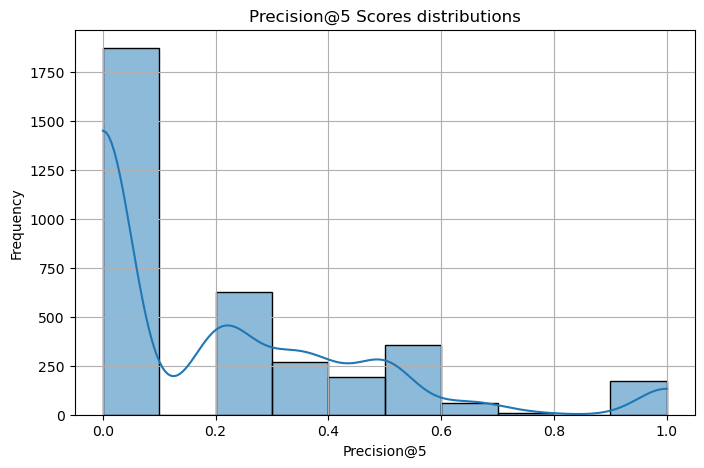

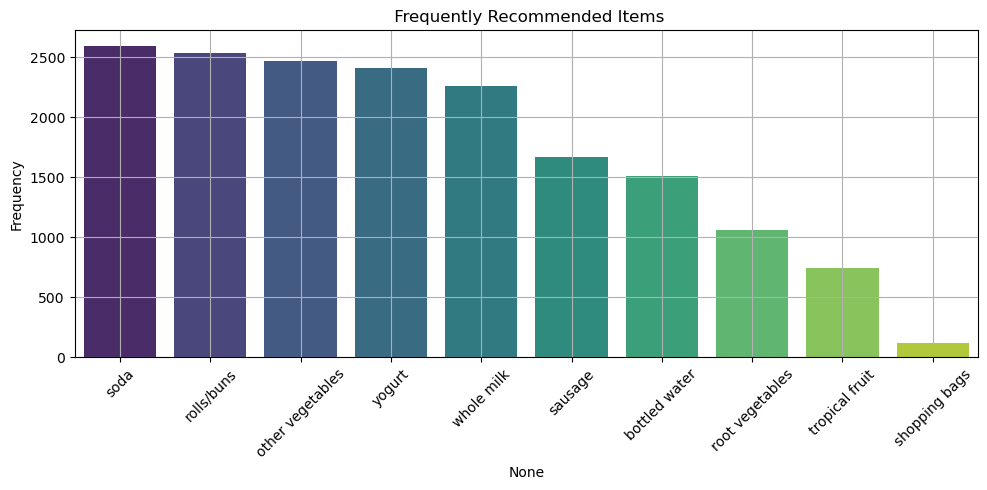

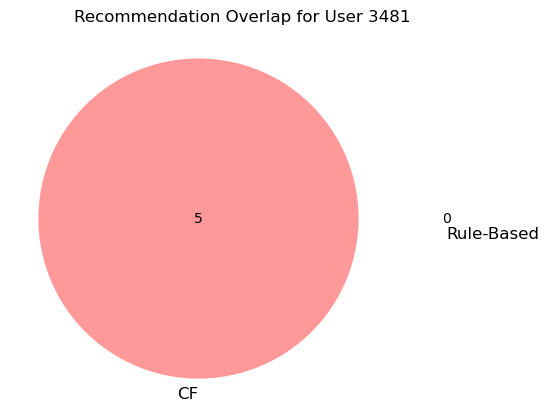

In [38]:
# 9. Visualizations

visual=''' In this part , we are just saving the final combined recommendations to csv and visualizing to analyse the task submission'''
print(visual)

# Precision@5 Distribution
plt.figure(figsize=(8, 5))
sns.histplot(precision_scores, bins=10, kde=True)
plt.title("Precision@5 Scores distributions")
plt.xlabel("Precision@5")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


# Top Recommended Items Frequency
all_recommended = [item for sublist in cf_result_combined.values() for item in sublist]
top_items_series = pd.Series(all_recommended).value_counts().head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_items_series.index, y=top_items_series.values, hue=top_items_series.index, palette='viridis', legend=False)
plt.title(" Frequently Recommended Items")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Venn Diagram for one user, Venn diagram is best to show similarities
cf_set = set(cf_result.get(sample_user, []))
rb_set = set(rule_result.get(sample_user, []))

plt.figure(figsize=(6, 6))
venn2([cf_set, rb_set], set_labels=('CF', 'Rule-Based'))
plt.title(f"Recommendation Overlap for User {sample_user}")
plt.show()












## Result

In [39]:
result=(''' Our this code will generate a cf_recommendation.CSV file which will have the collaborative filtering list done using the patterns provided in part 1''')
print(result)

 Our this code will generate a cf_recommendation.CSV file which will have the collaborative filtering list done using the patterns provided in part 1


## References

In [40]:
references=('''
Journal Articles:

[1] Fareed, A., Hassan, S., Belhaouari, S.B. & Halim, Z., n.d. A collaborative filtering recommendation framework utilizing social networks. [online] Available at: [link not provided].

[2] Roy, D. & Dutta, M., 2022. A systematic review and research perspective on recommender systems. Journal of Big Data, 9(59). https://doi.org/10.1186/s40537-022-00591-x

[3] Zahoor, M., Hassan, S., Belhaouari, S.B. & Halim, Z., 2017. Collaborative filtering recommender system: overview and challenges. Journal of Computational and Theoretical Nanoscience, 23(9), pp.9045–9049. https://doi.org/10.1166/asl.2017.10020


Web Sources:

[4] GeeksforGeeks, 2024. Collaborative Filtering in Machine Learning. [online] Available at: https://www.geeksforgeeks.org/collaborative-filtering-ml/ [Accessed 1 Jun 2025].

[5] Ajitsaria, A., n.d. Build a Recommendation Engine With Collaborative Filtering. [online] Available at: https://www.datacamp.com/tutorial/recommender-systems-python [Accessed 1 Jun 2025]. ''')

print(references)


Journal Articles:

[1] Fareed, A., Hassan, S., Belhaouari, S.B. & Halim, Z., n.d. A collaborative filtering recommendation framework utilizing social networks. [online] Available at: [link not provided].

[2] Roy, D. & Dutta, M., 2022. A systematic review and research perspective on recommender systems. Journal of Big Data, 9(59). https://doi.org/10.1186/s40537-022-00591-x

[3] Zahoor, M., Hassan, S., Belhaouari, S.B. & Halim, Z., 2017. Collaborative filtering recommender system: overview and challenges. Journal of Computational and Theoretical Nanoscience, 23(9), pp.9045–9049. https://doi.org/10.1166/asl.2017.10020


Web Sources:

[4] GeeksforGeeks, 2024. Collaborative Filtering in Machine Learning. [online] Available at: https://www.geeksforgeeks.org/collaborative-filtering-ml/ [Accessed 1 Jun 2025].

[5] Ajitsaria, A., n.d. Build a Recommendation Engine With Collaborative Filtering. [online] Available at: https://www.datacamp.com/tutorial/recommender-systems-python [Accessed 1 Jun 

### Augmentation of the Recommender System

In addition to the association rules mining and item-item collaborative filtering established by earlier research in (Lee, Kim & Rhee 2001) and (Parvatikar & Joshi 2015), the factor I have chosen to augment our recommender system with is the recency bias of purchases made by customers.

As part of the design of recommender systems, an evaluation of the recommendations must be determined, ranking the top-k recommendations to show users. As humans are dynamic evolving individuals. One significant factor is the recency and seasonality of purchases, with some research suggesting tracking the regularity of purchases made by consumers can improve recommendations (Zhou & Hirasawa 2019).

Other research suggests the use of time-sensitive LSTM models in recommender systems can emphasise the short-term changes in customers by better tracking the latent factors of products and customers (Rabiu et al. 2021).

The equation that we have developed to prioritise the most recent purchases first is:
$w(t)=e^{−λ⋅Δt}$
Where:
- $Δt$ = time since the purchase in days
- $λ$ = decay rate (hyperparameter tuneable)

This allows the most recent purchases to be set to 1 in the customer-item matrix, and causes decay for older purchased items. This also helps normalise the scores but setting the range to (0,1]. When calculating cosine similarity, this decay will affect the dot-product outcome such that those items that have decayed will be considered less similar than items that have not decayed.

References

Lee, C.H., Kim, Y.H. and Rhee, P.K., 2001. Web personalization expert with combining collaborative filtering and association rule mining technique. Expert Systems with Applications, 21(3), pp.131-137.

Parvatikar, S. and Joshi, B., 2015, December. Online book recommendation system by using collaborative filtering and association mining. In 2015 IEEE International Conference on Computational Intelligence and Computing Research (ICCIC) (pp. 1-4). IEEE.

Rabiu, I, Salim, N, Da'u, A & Nasser, M 2021, 'Modeling sentimental bias and temporal dynamics for adaptive deep recommendation system', Expert Systems with Applications, vol. 191, 116262.

Zhou, H & Hirasawa, K 2019, 'Evolving temporal association rules in recommender system', Neural Computing and Applications, vol. 31, pp. 2605–2619.


In [41]:
# Import standard DS libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import for preprocessing
from datetime import datetime

# Import for collaborative filtering
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict

# Import for temporal decay calculation
from math import exp
from scipy.sparse import csr_matrix

In [42]:
def preprocess_groceries(df):
    """
    Function to preprocess the csv files of Groceries data.

    Intakes a dataframe and corrects the datatypes and removes null values
    
    Returns the same dataframe after processing
    """
    # Apply a transformation for the date
    func = lambda x: datetime.strptime(x, "%d/%m/%Y")
    df['Date'] = df['Date'].apply(func)

    # Convert and clean data types
    df['User_id'] = df['Member_number'].astype('Int64')
    df['year'] = df['year'].astype('Int64')
    df['month'] = df['month'].astype('Int64')
    df['day'] = df['day'].astype('Int64')
    df['day_of_week'] = df['day_of_week'].astype('Int64')

    # Remove any null value rows missing member-ids or date information
    if df.isna().sum().sum():
        df = df.dropna()


    # Group by date and customer ID
    df_group = df.groupby(['Member_number', 'Date'])['itemDescription']

    # Make the groupby output into a list and return all columns to the dataframe
    basket_df = df_group.apply(list).reset_index()

    return basket_df

In [43]:
def get_member_item_matrix(data, lambda_decay=0.01):
    """
    Function to build user-item interactions with time decay to each member

    Intakes a dataframe and a lambda decay factor

    Returns the user-item matrix with temporal decay
    """

    # Returns the most recent date (max) of each member
    member_dict_df = data.groupby('Member_number').max()
    
    # Makes dict for easy referal
    member_date_dict = member_dict_df['Date'].to_dict()

    # Creates a dict item that creates a key-value pair if a key is not founc
    mem_item_decay = defaultdict(dict)

    # For each user's purchases
    for row in data.itertuples():
        # Identify the customer, their purchased items and the purchase date
        user, basket, time = row.Member_number, row.itemDescription, row.Date

        # Identify their most recent transaction date
        current_time = member_date_dict[user]

        # Define the difference in delays in days
        delta_days = (current_time - time).days

        # Calculate a exponentially decaying function, from 1-0 based on how many days ago the purchase was.
        decay_weight = exp(-lambda_decay * delta_days)
        
        # For each item in the purchase
        for item in basket:
            # Indicate the user purchased the item and how long ago
            mem_item_decay[user][item] = decay_weight

    # Fill all non-purchased items of users with the value 0
    df = pd.DataFrame(mem_item_decay).fillna(0)

    return df

In [44]:
def get_cf_decay_recommendations(df, mem_item_matrix, top_k=5, score=False):
    """
    Function to get item-item recommendations for a dataframe of usesr
    
    Intakes a purchases matrix and a dataframe

    Returns n recommendations of items that can be purchased
    """

    # Create a dataframe of the cosine similarity of items
    item_similarity_df = pd.DataFrame(cosine_similarity(mem_item_matrix),
                                  index=mem_item_matrix.index,
                                  columns=mem_item_matrix.index)
    
    # Initalise results and scores dict
    cf_result = {}
    cf_scores = {}

    # Create unique list of users in dataframe
    users = df['Member_number'].unique()

    # Create list of users who have made purchases
    recommendation_users = mem_item_matrix.columns

    # For each user
    for user in users:
        # For each recommendation
        if user in recommendation_users:
            # Vector of the purchases made of the users
            user_vector = mem_item_matrix.T.loc[user]

            # Get the dot product scores to the closest item similarities
            scores = item_similarity_df.dot(user_vector)

            # Filter out items the user has already purchased
            scores = scores[user_vector == 0]

            # Sort the recommendation values and select on the top n items
            cf_result[user] = scores.sort_values(ascending=False).head(top_k).index.tolist()

            # Sort the recommendation values and select the top scores
            cf_scores[user] = scores.sort_values(ascending=False).head(top_k)
            
    if score: 
        return cf_scores
    else:
        return cf_result

In [45]:
# Import both sets of data
train_df = pd.read_csv("Groceries data train.csv")
test_df = pd.read_csv("Groceries data test.csv")

# Apply the above function to preprocess our datasets
basket_train_df = preprocess_groceries(train_df)
basket_test_df = preprocess_groceries(test_df)

basket_train_df.head(3)

,Member_number,Date,itemDescription
0,1000,2014-06-24,[pastry]
1,1000,2015-03-15,"[sausage, yogurt]"
2,1000,2015-05-27,"[soda, pickled vegetables]"


In [46]:
# Create a user-item matrix of weights, with temporal decay
user_item_matrix_decay = get_member_item_matrix(basket_train_df)

# Get CF recommendations based on cosine similarity
cf_result = get_cf_decay_recommendations(basket_train_df, user_item_matrix_decay)

# Get CF recommendations based on cosine similarity of items in the training data
cf_test_result = get_cf_decay_recommendations(basket_test_df, user_item_matrix_decay)

# Turn recommendations into dataframe
cf_decay_df = pd.DataFrame([
    {'Member_number': user, 'Recommended_Items': recommendations}
    for user, recommendations in cf_result.items() 
])

# Save the decay recommendations into a csv file
cf_decay_df.to_csv('cf_result_decay.csv')

In [47]:
# Import association rules from Task 1
rules_df = pd.read_csv("association_rules.csv")

# Initalise dictionary which will default to an empty list if key not found
rule_dict = defaultdict(list)

# For each row in the association rules
for _, row in rules_df.iterrows():
    # Grab the antecedent and consequent items
    antecedent = row['antecedents']
    consequent = row['consequents']

    # Add to the rules dictionary
    rule_dict[antecedent].append((consequent, row['confidence']))

In [48]:
def generate_apriori_scores(user_item_history, rule_dict):
    """
    Function to generate association rules for each user

    Intakes a dataframe and an association rules dictionary

    Returns a dictionary of item-scores that will be changed by apriori scores
    """
    # Initialise a dictionary for all user scores
    apriori_scores = defaultdict(dict)

    # For each item purchased by the user
    for user, items in user_item_history.items():
        # Initalise a dictionary for keeping the scores
        scores = defaultdict(float)

        # For each item of the user's purchases
        for item in items:
            # For each consequent and confidence value in the rule dictionary
            for consequent, conf in rule_dict.get(item, []):
                # Add the confidence of the item to the scores
                scores[consequent] += conf 

        # Set the apriori scores for this user
        apriori_scores[user] = scores
    
    return apriori_scores

In [49]:
def blend_scores(cf_scores, apriori_scores, alpha=0.5, top_k=5):
    """
    Function to get hybrid recommendations based on item-item CF scores and Apriori scores. 
    Tuneable hyperparameter alpha for if we want more CF scores or more Apriori scores.
    
    Intakes scores for CF item-item and apriori, and a alpha percentage and a top ranking selection

    Returns k recommendations of items 
    """
    
    # Initalise the dictionary for blended scores
    blended_scores = {}

    # for each customer ID
    for user in cf_scores.keys():
        # Initalise a final score dictionary
        final_scores = defaultdict(float)

        # For each item and its CF score
        for item, score in cf_scores[user].items():
            # Make that score the alpha percentage of the score
            final_scores[item] += alpha * score

        # for each item and its apriori score
        for item, score in apriori_scores.get(user, {}).items():
            #
            final_scores[item] += (1 - alpha) * score

        # Get top-k ranked scores in the blended scores
        ranked_items = sorted(final_scores.items(), key=lambda x: x[1], reverse=True)[:top_k]

        # Return the blended recommendations
        blended_scores[user] = [item for item, _ in ranked_items]
    
    return blended_scores

In [50]:
# Get scores based on the Apriori recommendation
apriori_scores = generate_apriori_scores(user_item_matrix_decay, rule_dict)

# Get CF recommendations based on cosine similarity
cf_scores = get_cf_decay_recommendations(basket_train_df, user_item_matrix_decay, score=True)

# Get blended recommendations based on CF and Apriori rules
blended_scores = blend_scores(cf_scores, apriori_scores, top_k=5)

# Turn recommendations into dataframe
blended_df = pd.DataFrame([
    {'Member_number': user, 'Recommended_Items': recommendations}
    for user, recommendations in blended_scores.items() 
])

# Save the decay recommendations into a csv file
blended_df.to_csv('blended_result_recommendations.csv')

### Evaluation of the best recommender model

Our only metrics available to us are accuracy-based metrics. We do not have any access to customer reviews or online AB testing.

In [51]:
def precision_at_k(recommended, actual, k):
    """
    Function to evaluate precision at k-items
    """
    recommended_k = recommended[:k]
    hits = set(recommended_k) & set(actual)
    return len(hits) / k

def recall_at_k(recommended, actual, k):
    """
    Function to evaluate recall at k-items
    """
    recommended_k = recommended[:k]
    hits = set(recommended_k) & set(actual)
    return len(hits) / len(actual) if actual else 0

In [52]:
# Get CF recommendations based on cosine similarity
cf_scores_test = get_cf_decay_recommendations(basket_test_df, user_item_matrix_decay, score=True)

# Get blended recommendations based on CF and Apriori rules
blended_scores_test = blend_scores(cf_scores, apriori_scores, top_k=5)

# Actual items in the basket
test_actual = test_df.groupby('Member_number')['itemDescription'].apply(list).to_dict()

In [53]:
# Initialise a list of precision scores
precision_scores = []
recall_scores = []

# For each user
for user in blended_scores_test:
    # Get their real purchase history
    actual_items = test_actual.get(user, [])
    recommended_items = blended_scores_test.get(user, [])

    # Append the precision score
    precision_scores.append(precision_at_k(recommended_items, actual_items, 5))

    # Append the recall score
    recall_scores.append(recall_at_k(recommended_items, actual_items, 5))

# Evaluate the average precision score
round(sum(precision_scores)/len(precision_scores),5)

0.1038

In [80]:
def evaluate_model(decay, alpha, k):
    """
    Pipeline function to take the data, preprocess it and get recommendations and then to evaluate those recommendations

    Intakes input of decay and alpha hyperparameters and the number of recommended items to return

    Returns the average precision and recall for the recommender model
    """
    # Import both sets of data
    train_df = pd.read_csv("Groceries data train.csv")
    test_df = pd.read_csv("Groceries data test.csv")
    
    # Apply the above function to preprocess our datasets
    basket_train_df = preprocess_groceries(train_df)
    basket_test_df = preprocess_groceries(test_df)

    # Create a user-item matrix of weights, with temporal decay from the training data
    user_item_matrix_decay = get_member_item_matrix(basket_train_df)
    
    # Import association rules from Task 1
    rules_df = pd.read_csv("association_rules.csv")
    
    # Initalise dictionary which will default to an empty list if key not found
    rule_dict = defaultdict(list)
    
    # For each row in the association rules
    for _, row in rules_df.iterrows():
        # Grab the antecedent and consequent items
        antecedent = row['antecedents']
        consequent = row['consequents']
    
        # Add to the rules dictionary
        rule_dict[antecedent].append((consequent, row['confidence']))    
        
    # Get scores based on the Apriori recommendation
    apriori_scores = generate_apriori_scores(user_item_matrix_decay, rule_dict)
    
    # Get CF recommendations based on cosine similarity
    cf_scores_test = get_cf_decay_recommendations(basket_test_df, user_item_matrix_decay, score=True)
    
    # Get blended recommendations based on CF and Apriori rules
    blended_scores_test = blend_scores(cf_scores, apriori_scores, alpha=alpha, top_k=k)

    # Initialise a list of precision scores
    precision_scores = []
    recall_scores = []
    
    # For each user
    for user in blended_scores_test:
        # Get their real purchase history
        actual_items = test_actual.get(user, [])
        recommended_items = blended_scores_test.get(user, [])
    
        # Append the precision score
        precision_scores.append(precision_at_k(recommended_items, actual_items, 5))
    
        # Append the recall score
        recall_scores.append(recall_at_k(recommended_items, actual_items, 5))
    
    # Evaluate the average precision score and recall score
    avg_precision = round(sum(precision_scores)/len(precision_scores),4)
    recall_precision = round(sum(recall_scores)/len(recall_scores),4)

    return avg_precision, recall_precision

In [81]:
# Grid search lists for the parameters
lambda_decays = [0.003,0.01,0.03,0.1]
alpha_percentages = [0.1,0.25,0.5,0.75,0.9]
k_types = [3,5,7,9,11,13]

# Initialise dataframe for collecting results
results = []

# cycle through the parameters
for lam in lambda_decays:
    for alpha in alpha_percentages:
        for k in k_types:
            # Evaluate the model
            print(f"Evaluating model at..lambda={lam}, alpha={alpha}, k={k}")
            avg_precision, avg_recall = evaluate_model(lam, alpha, k)

            # Calculate F1 score
            F1 = round(2 * (avg_precision * avg_recall) / (avg_precision + avg_recall),4)
            print(f"Model is... Precision:{avg_precision}, Recall:{avg_recall}, F1:{F1}")
            
            # Store the results in the dataframe
            results.append([lam, alpha, k, avg_precision, avg_recall, F1])

Evaluating model at..lambda=0.003, alpha=0.1, k=3
Model is... Precision:0.0704, Recall:0.1126, F1:0.0866
Evaluating model at..lambda=0.003, alpha=0.1, k=5
Model is... Precision:0.1038, Recall:0.1633, F1:0.1269
Evaluating model at..lambda=0.003, alpha=0.1, k=7
Model is... Precision:0.1038, Recall:0.1633, F1:0.1269
Evaluating model at..lambda=0.003, alpha=0.1, k=9
Model is... Precision:0.1038, Recall:0.1633, F1:0.1269
Evaluating model at..lambda=0.003, alpha=0.1, k=11
Model is... Precision:0.1038, Recall:0.1633, F1:0.1269
Evaluating model at..lambda=0.003, alpha=0.1, k=13
Model is... Precision:0.1038, Recall:0.1633, F1:0.1269
Evaluating model at..lambda=0.003, alpha=0.25, k=3
Model is... Precision:0.0704, Recall:0.1126, F1:0.0866
Evaluating model at..lambda=0.003, alpha=0.25, k=5
Model is... Precision:0.1038, Recall:0.1633, F1:0.1269
Evaluating model at..lambda=0.003, alpha=0.25, k=7
Model is... Precision:0.1038, Recall:0.1633, F1:0.1269
Evaluating model at..lambda=0.003, alpha=0.25, k=9

In [82]:
# Results
df_results = pd.DataFrame(results, columns = ['lambda', 'alpha', 'topk', 'avg_precision', 'avg_recall', "F1_score"])

In [83]:
# Select the top performing models by the metrics
df_results.sort_values('F1_score', ascending=False)

,lambda,alpha,topk,avg_precision,avg_recall,F1_score
104,0.100,0.50,7,0.1038,0.1633,0.1269
105,0.100,0.50,9,0.1038,0.1633,0.1269
106,0.100,0.50,11,0.1038,0.1633,0.1269
107,0.100,0.50,13,0.1038,0.1633,0.1269
109,0.100,0.75,5,0.1038,0.1633,0.1269
...,...,...,...,...,...,...
24,0.003,0.90,3,0.0704,0.1126,0.0866
30,0.010,0.10,3,0.0704,0.1126,0.0866
18,0.003,0.75,3,0.0704,0.1126,0.0866
12,0.003,0.50,3,0.0704,0.1126,0.0866


# Report Task - EDA Visualisations (Vincent Guan - a1952075)

In [58]:
# Combine dataframes for EDA
total_df = pd.concat([train_df, test_df])

# items
NUM_OF_ITEMS = 15

# top items
top_items = total_df['itemDescription'].value_counts().head(NUM_OF_ITEMS+5).tail(NUM_OF_ITEMS).index.tolist()

# build the co-occurrence matrix
co_matrix = pd.DataFrame(np.zeros((NUM_OF_ITEMS, NUM_OF_ITEMS)), index=top_items, columns=top_items)

# Group by date and customer ID
df_group = total_df.groupby(['Member_number', 'Date'])['itemDescription']

# Make the groupby output into a list and return all columns to the dataframe
basket_df = df_group.apply(list)

In [59]:
top_counts = total_df['itemDescription'].value_counts()[:10]

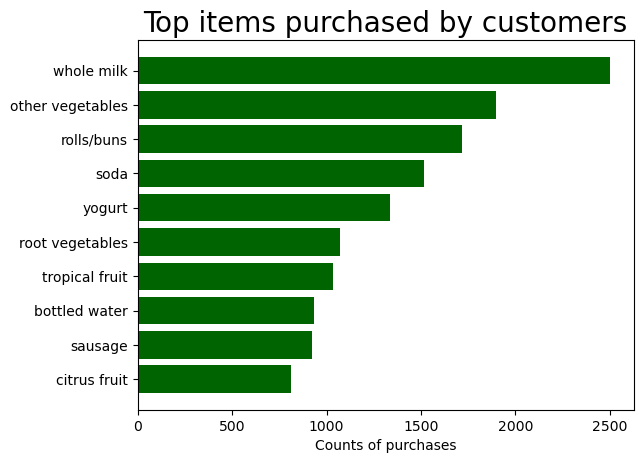

In [60]:
plt.barh(top_counts.index[::-1], top_counts[::-1], color='darkgreen')
plt.title("Top items purchased by customers", fontsize=20)
plt.xlabel("Counts of purchases")
plt.show()

In [61]:
# for each basket
for basket in basket_df:
    # for each item-item combination
    for item_x in basket:
        
        for item_y in basket:
            if item_x==item_y: continue
            try:
                co_matrix.loc[item_x,item_y]+=1
            except KeyError:
                pass

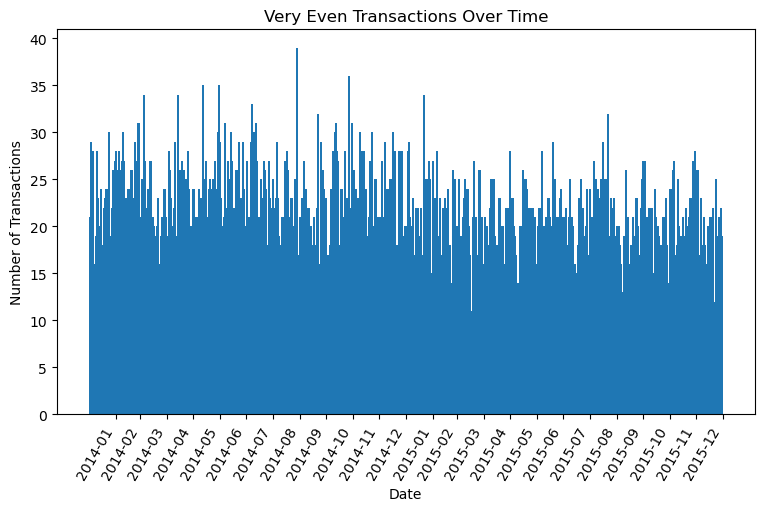

In [62]:
# Apply a transformation for the date
func = lambda x: datetime.strptime(x, "%d/%m/%Y")
#total_df['Date'] = total_df['Date'].apply(func)

# Transactions over time
transactions_over_time = basket_df.groupby('Date').size().reset_index()

# Monthly timestamps
timestamps = pd.date_range(start='2014-01-01', periods=24, freq='ME')

# Plot many things
plt.figure(figsize=(9, 5))
plt.bar(transactions_over_time['Date'], transactions_over_time['itemDescription'], width=2.5)
plt.xticks(timestamps, [ts.strftime('%Y-%m') for ts in timestamps], rotation=60, ha='right')
plt.title("Very Even Transactions Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Transactions")
plt.show()

In [63]:
# Set style of graphs
sns.set_style("darkgrid")

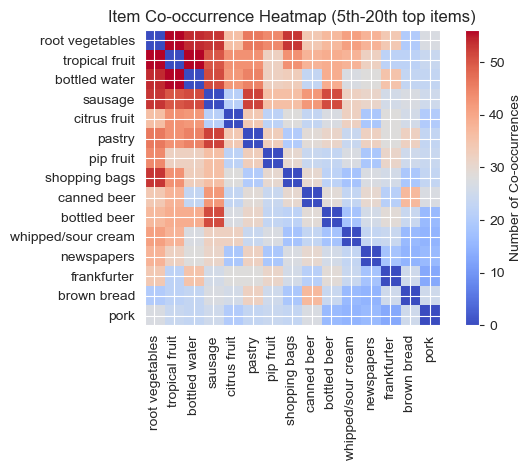

In [64]:
# Plot all
plt.imshow(co_matrix, interpolation='nearest', cmap='coolwarm')
plt.title("Item Co-occurrence Heatmap (5th-20th top items)")
plt.xticks(ticks=np.arange(NUM_OF_ITEMS), labels=top_items, rotation=90)
plt.yticks(ticks=np.arange(NUM_OF_ITEMS), labels=top_items)
plt.colorbar(label="Number of Co-occurrences")
plt.tight_layout()
plt.show()

In [65]:
# Number of unique items in store
len(total_df['itemDescription'].value_counts())

167

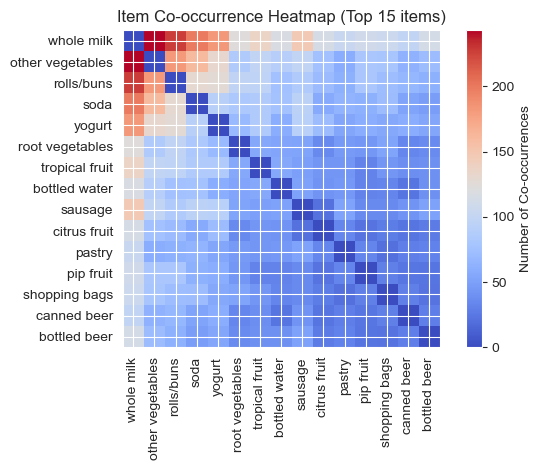

In [66]:
# Combine dataframes for EDA
total_df = pd.concat([train_df, test_df])

# items
NUM_OF_ITEMS = 15

# top items
top_items = total_df['itemDescription'].value_counts().head(NUM_OF_ITEMS).tail(NUM_OF_ITEMS).index.tolist()

# build the co-occurrence matrix
co_matrix = pd.DataFrame(np.zeros((NUM_OF_ITEMS, NUM_OF_ITEMS)), index=top_items, columns=top_items)

# Group by date and customer ID
df_group = total_df.groupby(['Member_number', 'Date'])['itemDescription']

# Make the groupby output into a list and return all columns to the dataframe
basket_df = df_group.apply(list)

# for each basket
for basket in basket_df:
    # for each item-item combination
    for item_x in basket:
        
        for item_y in basket:
            if item_x==item_y: continue
            try:
                co_matrix.loc[item_x,item_y]+=1
            except KeyError:
                pass
                
# Plot
plt.imshow(co_matrix, interpolation='nearest', cmap='coolwarm')
plt.title("Item Co-occurrence Heatmap (Top 15 items)")
plt.xticks(ticks=np.arange(NUM_OF_ITEMS), labels=top_items, rotation=90)
plt.yticks(ticks=np.arange(NUM_OF_ITEMS), labels=top_items)
plt.colorbar(label="Number of Co-occurrences")
plt.tight_layout()
plt.show()

In [67]:
basket_df

Member_number  Date      
1000           2014-06-24                    [pastry, whole milk, salty snack]
               2015-03-15    [sausage, yogurt, semi-finished bread, whole m...
               2015-05-27                           [soda, pickled vegetables]
               2015-07-24                       [misc. beverages, canned beer]
               2015-11-25                          [sausage, hygiene articles]
                                                   ...                        
4999           2015-05-16                    [butter milk, whipped/sour cream]
               2015-12-26                               [herbs, bottled water]
5000           2014-09-03                      [onions, fruit/vegetable juice]
               2014-11-16                     [other vegetables, bottled beer]
               2015-10-02         [soda, semi-finished bread, root vegetables]
Name: itemDescription, Length: 14963, dtype: object

In [68]:
#Deviation from the average for day of the week transactions
mean = int(dow.values.mean())
dev = dow.apply(lambda x: round(100*(((x)/mean)-1),2))
dev

/Users/vincent/Documents/anaconda3/lib/python3.12/site-packages/executing/executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
/Users/vincent/Documents/anaconda3/lib/python3.12/site-packages/executing/executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
/Users/vincent/Documents/anaconda3/lib/python3.12/ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)
/Users/vincent/Documents/anaconda3/lib/python3.12/site-packages/executing/executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
/Users/vincent/Documents/anaconda3/lib/python3.12/ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in 

NameError: name 'dow' is not defined

In [ ]:
#Deviation from the average for monthly transactions
average = int(monthly.values.mean())
monthly.apply(lambda x: round(100*(((x)/average)-1),2))

In [ ]:
# Transactions per day of week
plt.figure(figsize=(4,2))
dow = total_df['day_of_week'].value_counts().sort_index()
sns.barplot(x=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], y=dow.values, color='royalblue')
plt.title("Very Even Transactions by Day of the Week")
plt.axhline(int(dow.values.mean()), color='yellow')
plt.xlabel("Day of Week")
plt.ylabel("Number of Transactions")
plt.tight_layout()
plt.show()
            
# Transactions per month
plt.figure(figsize=(6,2))
monthly = total_df['month'].value_counts().sort_index()
sns.barplot(x=monthly.index, y=monthly.values, color="green")
plt.axhline(int(monthly.values.mean()), color='yellow')
plt.title("Very Even Transactions by Month")
plt.xlabel("Month")
plt.ylabel("Number of Transactions")
plt.show()

In [ ]:
# Histogram of items per basket
basket_sizes = pd.DataFrame(basket_df)['itemDescription'].apply(lambda x: len(x))
plt.figure()
plt.hist(basket_sizes, bins=range(1, basket_sizes.max()+2), color='blue')
plt.title("Most customers only purchased a small number per shop", fontsize=20)
plt.xlabel("Number of Items")
plt.ylabel("Frequency (n)")
plt.tight_layout()
plt.show()

In [ ]:
# Histogram of unique items per user
items_per_user = total_df.groupby('User_id')['itemDescription'].nunique()
plt.figure()
plt.hist(items_per_user, bins=range(0,max(items_per_user)+1), color='green')
plt.title("Most customers purchased a variety of unique items from this shop.", fontsize=20)
plt.xlabel("Number of Unique Items")
plt.ylabel("Customers")
plt.tight_layout()
plt.show()

# Report Task - Generate Recommendations from specific rules (Vincent)

In [130]:
def generate_recommendations_from_rules(rules_df, user_basket, top_n=2):
    """
    Given a user's basket, return up to `top_n` recommended items
    from the association rules, with traceable rule origin.
    """
    recommendations = []

    for _, row in rules_df.iterrows():
        antecedent = set(row['antecedents'])
        consequent = set(row['consequents'])

        # If user basket includes all items in antecedent
        if antecedent.issubset(user_basket):
            for item in consequent:
                if item not in user_basket:  # Avoid recommending something they already have
                    recommendations.append({
                        'recommended_item': item,
                        'triggered_by': antecedent,
                        'support': row['support'],
                        'confidence': row['confidence'],
                        'lift': row['lift']
                    })

    # Sort by confidence or lift (optional)
    recommendations = sorted(recommendations, key=lambda x: x['confidence'], reverse=True)
    return recommendations[:top_n]

In [147]:
rules2 = rules[rules['consequents'] != whole_milk]

In [152]:
rules3 = rules2[:5]

In [156]:
for row in basket_df.iterrows():
    basket = set(row[1]['itemDescription'])

    # Get recommendations with trace
    recs = generate_recommendations_from_rules(rules3, basket)
    
    # Display the traced recommendations
    for rec in recs:
        print(f"Recommendation {rec['recommended_item']} to #{row[1]['Member_number']} because of a {rec['triggered_by']} purchase.")
        print(f" - Support: {rec['support']:.4f}, Confidence: {rec['confidence']:.2f}, Lift: {rec['lift']:.2f}\n")
   

Recommendation other vegetables to #1001 because of a {'frankfurter'} purchase.
 - Support: 0.0031, Confidence: 0.11, Lift: 1.16

Recommendation rolls/buns to #1004 because of a {'pip fruit'} purchase.
 - Support: 0.0031, Confidence: 0.08, Lift: 1.02

Recommendation soda to #1004 because of a {'shopping bags'} purchase.
 - Support: 0.0029, Confidence: 0.08, Lift: 1.10

Recommendation rolls/buns to #1004 because of a {'shopping bags'} purchase.
 - Support: 0.0028, Confidence: 0.08, Lift: 0.95

Recommendation other vegetables to #1006 because of a {'frankfurter'} purchase.
 - Support: 0.0031, Confidence: 0.11, Lift: 1.16

Recommendation soda to #1006 because of a {'shopping bags'} purchase.
 - Support: 0.0029, Confidence: 0.08, Lift: 1.10

Recommendation rolls/buns to #1006 because of a {'shopping bags'} purchase.
 - Support: 0.0028, Confidence: 0.08, Lift: 0.95

Recommendation rolls/buns to #1010 because of a {'pip fruit'} purchase.
 - Support: 0.0031, Confidence: 0.08, Lift: 1.02

Reco

KeyboardInterrupt: 

# Report Task - Evaluation of multiple models (Vincent)

In [ ]:
def evaluate_model(decay, alpha, k):
    """
    Pipeline function to take the data, preprocess it and get recommendations and then to evaluate those recommendations

    Intakes input of decay and alpha hyperparameters and the number of recommended items to return

    Returns the average precision and recall for the recommender model
    """
    # Import both sets of data
    train_df = pd.read_csv("Groceries data train.csv")
    test_df = pd.read_csv("Groceries data test.csv")
    
    # Apply the above function to preprocess our datasets
    basket_train_df = preprocess_groceries(train_df)
    basket_test_df = preprocess_groceries(test_df)

    # Create a user-item matrix of weights, with temporal decay from the training data
    user_item_matrix_decay = get_member_item_matrix(basket_train_df)
    
    # Import association rules from Task 1
    rules_df = pd.read_csv("association_rules.csv")
    
    # Initalise dictionary which will default to an empty list if key not found
    rule_dict = defaultdict(list)
    
    # For each row in the association rules
    for _, row in rules_df.iterrows():
        # Grab the antecedent and consequent items
        antecedent = row['antecedents']
        consequent = row['consequents']
    
        # Add to the rules dictionary
        rule_dict[antecedent].append((consequent, row['confidence']))    
        
    # Get scores based on the Apriori recommendation
    apriori_scores = generate_apriori_scores(user_item_matrix_decay, rule_dict)
    
    # Get CF recommendations based on cosine similarity
    cf_scores_test = get_cf_decay_recommendations(basket_test_df, user_item_matrix_decay, score=True)
    
    # Get blended recommendations based on CF and Apriori rules
    blended_scores_test = blend_scores(cf_scores, apriori_scores, top_k=k)

    # Initialise a list of precision scores
    precision_scores = []
    recall_scores = []
    
    # For each user
    for user in blended_scores_test:
        # Get their real purchase history
        actual_items = test_actual.get(user, [])
        recommended_items = blended_scores_test.get(user, [])
    
        # Append the precision score
        precision_scores.append(precision_at_k(recommended_items, actual_items, 5))
    
        # Append the recall score
        recall_scores.append(recall_at_k(recommended_items, actual_items, 5))
    
    # Evaluate the average precision score and recall score
    avg_precision = round(sum(precision_scores)/len(precision_scores),4)
    recall_precision = round(sum(recall_scores)/len(recall_scores),4)

    return avg_precision, recall_precision

In [109]:
# we are preparing the test ground
test_actual = test_df.groupby('Member_number')['itemDescription'].apply(list).to_dict()

precision_scores = [] # here we will calculate the precision
recall_scores = []

for user in cf_result_combined:
    actual_items = test_actual.get(user, [])
    recommended_items = cf_result_combined.get(user, [])
    precision_scores.append(precision_at_k(recommended_items, actual_items))
    recall_scores.append(recall_at_k(recommended_items, actual_items))

print("\nOur Average precision is Calculated\n")
average_precision = np.mean(precision_scores)
print(f"Average Precision@5: {average_precision:.4f}")

print("\nOur Recall precision is Calculated\n")
average_recall = np.mean(recall_scores)
print(f"Average Recall@5: {average_recall:.4f}")

# sample output that will show the Recommendations
sample_user = test_users[0]
print(f"\nRecommendations for User {sample_user}: {cf_result_combined[sample_user]}")

# Calculate F1 score
F1 = 2*round((average_precision * average_recall) / (average_precision + average_recall),4)
F1


Our Average precision is Calculated

Average Precision@5: 0.1986

Our Recall precision is Calculated

Average Recall@5: 0.1893

Recommendations for User 3481: ['rolls/buns', 'sausage', 'bottled water', 'tropical fruit', 'root vegetables']


0.1938

In [91]:
# we are preparing the test ground
test_actual = test_df.groupby('Member_number')['itemDescription'].apply(list).to_dict()

precision_scores = [] # here we will calculate the precision
recall_scores = []

for user in cf_result_combined:
    actual_items = test_actual.get(user, [])
    recommended_items = cf_result.get(user, [])
    precision_scores.append(precision_at_k(recommended_items, actual_items))
    recall_scores.append(recall_at_k(recommended_items, actual_items))

print("\nOur Average precision is Calculated\n")
average_precision = np.mean(precision_scores)
print(f"Average Precision@5: {average_precision:.4f}")

print("\nOur Recall precision is Calculated\n")
average_recall = np.mean(recall_scores)
print(f"Average Recall@5: {average_recall:.4f}")

# sample output that will show the Recommendations
sample_user = test_users[0]
print(f"\nRecommendations for User {sample_user}: {cf_result_combined[sample_user]}")

# Calculate F1 score
F1 = 2*round((average_precision * average_recall) / (average_precision + average_recall),4)
F1

In this step we are evaluating how precise our combined recommendations are by calculating the presion@5 for each user , this will let us know out of 5 recommend items , how many were actually considered by the user ,this will give a report on the recommendations we are doing

Our Average precision is Calculated

Average Precision@5: 0.1860

Our Recall precision is Calculated

Average Recall@5: 0.1773

Recommendations for User 3481: ['rolls/buns', 'sausage', 'bottled water', 'tropical fruit', 'root vegetables']


0.1816

In [130]:
items2 = total_df.itemDescription.value_counts()
groceries_items = list(items2.index)

def selectRandom(groceries_items, k=5):
    N = len(groceries_items)
    l_ = []
    
    for _ in range(k):
        rand = np.random.randint(0,N)
        l_.append(groceries_items[rand])

    return l_

In [132]:
# we are preparing the test ground
test_actual = test_df.groupby('Member_number')['itemDescription'].apply(list).to_dict()

precision_scores = [] # here we will calculate the precision
recall_scores = []

for user in cf_result_combined:
    actual_items = test_actual.get(user, [])
    recommended_items = selectRandom(groceries_items, k=5)
    precision_scores.append(precision_at_k(recommended_items, actual_items))
    recall_scores.append(recall_at_k(recommended_items, actual_items))

print("\nOur Average precision is Calculated\n")
average_precision = np.mean(precision_scores)
print(f"Average Precision@5: {average_precision:.4f}")

print("\nOur Recall precision is Calculated\n")
average_recall = np.mean(recall_scores)
print(f"Average Recall@5: {average_recall:.4f}")

# sample output that will show the Recommendations
sample_user = test_users[0]
print(f"\nRecommendations for User {sample_user}: {cf_result_combined[sample_user]}")

# Calculate F1 score
F1 = 2*round((average_precision * average_recall) / (average_precision + average_recall),4)
F1


Our Average precision is Calculated

Average Precision@5: 0.0312

Our Recall precision is Calculated

Average Recall@5: 0.0297

Recommendations for User 3481: ['rolls/buns', 'sausage', 'bottled water', 'tropical fruit', 'root vegetables']


0.0304

In [72]:
# Evaluate the model
avg_precision, avg_recall = evaluate_model(0.1, 0.5, 5)

# Calculate F1 score
F1 = round(2 * (avg_precision * avg_recall) / (avg_precision + avg_recall),4)
print(f"Model is... Precision:{avg_precision}, Recall:{avg_recall}, F1:{F1}")

Model is... Precision:0.1038, Recall:0.1633, F1:0.1269


In [73]:
# Evaluate the model
avg_precision, avg_recall = evaluate_model(0.1, 0, 5)

# Calculate F1 score
F1 = round(2 * (avg_precision * avg_recall) / (avg_precision + avg_recall),4)
print(f"Model is... Precision:{avg_precision}, Recall:{avg_recall}, F1:{F1}")

Model is... Precision:0.1038, Recall:0.1633, F1:0.1269


In [74]:
# Evaluate the model
avg_precision, avg_recall = evaluate_model(0.1, 1, 5)

# Calculate F1 score
F1 = round(2 * (avg_precision * avg_recall) / (avg_precision + avg_recall),4)
print(f"Model is... Precision:{avg_precision}, Recall:{avg_recall}, F1:{F1}")

Model is... Precision:0.1038, Recall:0.1633, F1:0.1269


In [133]:
results_list = [['Random', 0.0312,0.0297, 0.0304],
    ['FP Rules only',0.1038, 0.1633, 0.1269],
['CF only',0.1860, 0.1773, 0.1816],
['Hybrid',0.1986, 0.1893, 0.1938],
['Hybrid+recency-bias', 0.1038, 0.1633, 0.1269],
['CF recency-bias only', 0.1038, 0.1633, 0.1269]]

In [134]:
dfr = pd.DataFrame(results_list, columns=['Model','Avg Precision@5', 'Avg Recall@5', 'F1-score'])
dfr.head()

,Model,Avg Precision@5,Avg Recall@5,F1-score
0,Random,0.0312,0.0297,0.0304
1,FP Rules only,0.1038,0.1633,0.1269
2,CF only,0.1860,0.1773,0.1816
3,Hybrid,0.1986,0.1893,0.1938
4,Hybrid+recency-bias,0.1038,0.1633,0.1269


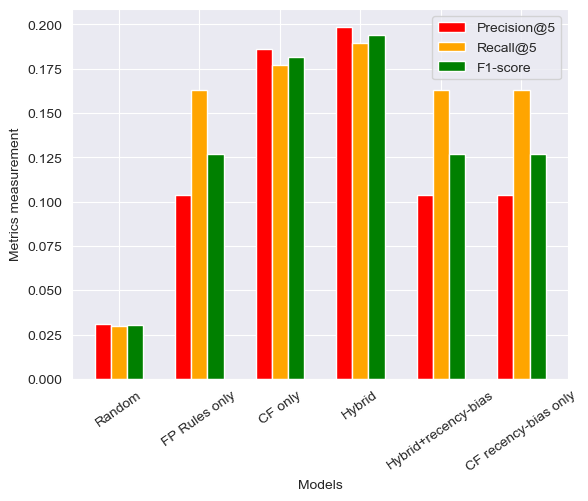

In [138]:
width = 0.2
x = np.arange(6)

# plot data in grouped manner of bar type
plt.bar(x-width, dfr['Avg Precision@5'], width, color='red')
plt.bar(x, dfr['Avg Recall@5'], width, color='orange')
plt.bar(x+width, dfr['F1-score'], width, color='green')
plt.xticks(x, dfr.Model, rotation=35)
plt.xlabel("Models")
plt.ylabel("Metrics measurement")
plt.legend(["Precision@5", 'Recall@5', 'F1-score'])
plt.show()